In [71]:
from transformers import logging

import random
import os

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

In [72]:
# setting up seed
seed = 123

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

logging.set_verbosity_error()

In [73]:
BATCH_SIZE = 32 # batch size used on the train and validation set
NUM_TRAIN_EPOCHS = 5 # number of iterations for the model training
MAX_SEQ_LENGTH = 128 # used to cut/pad the text into tokens

In [74]:
# Loading the dataset
path = '../../datasets/'
taxonomy = pd.read_csv(path + 'human.csv')
queries, labels = taxonomy['query'].to_numpy(), taxonomy['label'].to_numpy()

In [75]:
# Encoding the labels to binary values
# bin_encoder = LabelEncoder()
# taxonomy['label'] = bin_encoder.fit_transform(taxonomy['label'])

# labels = np_utils.to_categorical(taxonomy['label'], dtype="int64")

taxonomy['label'] = pd.Categorical(taxonomy['label'])
labels = taxonomy['label'].cat.codes

labels = np_utils.to_categorical(labels)


In [76]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=MAX_SEQ_LENGTH,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# initialize two arrays for input tensors
Xids = np.zeros((len(taxonomy), MAX_SEQ_LENGTH))
Xmask = np.zeros((len(taxonomy), MAX_SEQ_LENGTH))

for i, sentence in enumerate(taxonomy['query']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

In [77]:
# label_values = taxonomy['label'].values  # take label column in the dataframe as array
# labels = np.zeros((label_values.size, label_values.max()+1))  # initialize empty (all zero) label array
# labels[np.arange(label_values.size), label_values] = 1  # add ones in indices where we have a value

In [78]:
import tensorflow as tf

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# shuffle data and batch it
dataset = dataset.shuffle(500).batch(BATCH_SIZE)

In [79]:
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])

train_size = int(0.7 * DS_LEN)
val_size = int(0.1 * DS_LEN)
test_size = int(0.2 * DS_LEN)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

del dataset  # delete dataset to free up disk-space

In [80]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["categorical_accuracy"]
    val_accuracy = val_accuracy + history.history["val_categorical_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

In [81]:
from transformers import TFBertModel

def create_model():
    # initialize cased BERT model
    bert = TFBertModel.from_pretrained('bert-base-uncased')

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='attention_mask', dtype='int32')

    # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
    embeddings = bert(input_ids, attention_mask=mask)[0]

    X = tf.keras.layers.LSTM(64)(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    y = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(X)

    # define input and output layers of our model
    model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

    # freeze the BERT layer - otherwise we will be training 100M+ parameters...
    model.layers[2].trainable = False

    model.summary()
    return model

In [82]:
def train_full_model(full_train_dataset, val_dataset, test_dataset):
    model = create_model()
    
    model.compile(
        optimizer="adam", 
        loss="categorical_crossentropy",
        metrics=[            
            tf.keras.metrics.CategoricalAccuracy()
        ],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, verbose=1)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                "BERT_Human.h5", verbose=1, save_best_only=True)
    history = model.fit(full_train_dataset, validation_data=val_dataset, epochs=NUM_TRAIN_EPOCHS,
        callbacks=[early_stopping, model_checkpoint])
    
    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["categorical_accuracy"],
        history.history["val_categorical_accuracy"],
    )

    # Loading the best checkpoint
    model = tf.keras.models.load_model("BERT_Human.h5", custom_objects={"TFBertModel": TFBertModel})

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

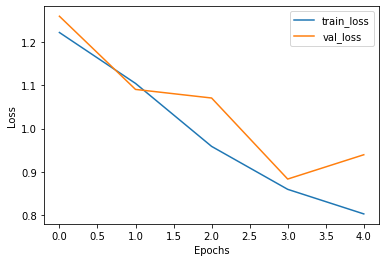

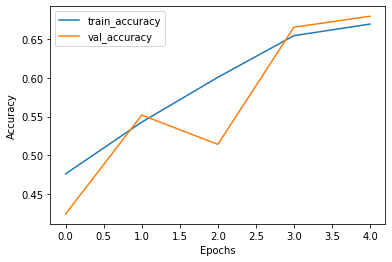

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.8510281443595886, 'categorical_accuracy': 0.6971153616905212}
----------------------------------------------------------------------------------------------------


In [83]:
# Training the model
full_dataset_model = train_full_model(train_dataset, val_dataset, test_dataset)